#**0. Introduction**



In [ ]:
!pip install spacy
!pip install scikit-multilearn keras #spacy-transformers transformers
!python -m spacy download nl_core_news_sm
!python -m spacy download nl_core_news_md
!python -m spacy download nl_core_news_lg

In [2]:
import os
import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.metrics import f1_score, hamming_loss
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB

from skmultilearn.model_selection import iterative_train_test_split
from skmultilearn.adapt import MLkNN
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.ensemble import RakelD
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix

from joblib import dump

import spacy
from spacy.training import Example
from spacy.util import minibatch
import random

#**1. Data Cleaning**

In [4]:
# Load the datasets
df_user_inputs = pd.read_csv('user_inputs.csv', delimiter=';')
df_labels = pd.read_csv('labels.csv', delimiter=";")

# Remove unnecessary index columns
df_user_inputs.drop(df_user_inputs.columns[0], axis=1, inplace=True)
df_labels.drop(df_labels.columns[0], axis=1, inplace=True)

# Remove classes with < 2 instances (this is only 'no complaints' label with 0 instance so not a big deal)
# We need to do this to split the data later with stratification
min_instances = 2
df_labels = df_labels.loc[:, (df_labels.sum(axis=0) >= min_instances)]

# Ensure alignment
assert len(df_labels) == len(df_user_inputs), "Datasets do not align!"

print(df_labels.shape)
df_user_inputs.head()

(3974, 74)


,text
0,Er is een teek op mijn been. Ik ben bang dat d...
1,Er is een teek op mijn rug en ik krijg hem er ...
2,Op mijn been zit een teek. Ik heb hem geprobee...
3,Ik heb allergieen
4,huid


In [5]:
# Preprocess user input text
# could be better and more advanced
def preprocess_text(text):
    """
    Preprocesses the input text by converting to lowercase and removing special characters.
    Args:
        text (str): The text to preprocess.
    Returns:
        str: The preprocessed text.
    """

    # Convert to lowercase
    text = text.lower()
    # Remove special characters
    text = re.sub(r'\W+', ' ', text)
    return text

df_user_inputs['text'] = df_user_inputs['text'].apply(preprocess_text)

df_user_inputs.head()

,text
0,er is een teek op mijn been ik ben bang dat di...
1,er is een teek op mijn rug en ik krijg hem er ...
2,op mijn been zit een teek ik heb hem geprobeer...
3,ik heb allergieen
4,huid


#**2. EDA**

Prevalence of 1 label per user input:  0.84


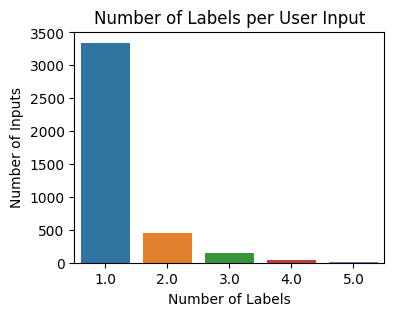

In [6]:
# Count number of labels per user input
num_labels_per_input = df_labels.sum(axis=1)
num_labels_distribution = num_labels_per_input.value_counts().sort_index()

# Display prevalence of single labels
single_label_prevalence = np.round(num_labels_distribution[1] / num_labels_distribution.sum(), 2)
print(f'Prevalence of 1 label per user input: {single_label_prevalence}')

# Plot distribution of the number of labels per input
plt.figure(figsize=(4, 3))
sns.barplot(x=num_labels_distribution.index, y=num_labels_distribution.values)
plt.title('Number of Labels per User Input')
plt.xlabel('Number of Labels')
plt.ylabel('Number of Inputs')
plt.xticks(range(len(num_labels_distribution.index)))
plt.show()

**Observation**: Most user inputs (84%) are associated with only 1 label. This implies that the problem might be less complex that a typical multi-label problem due to the predominance of single-label instances. But we still need to thoughtfully handle the multi-label aspect, especailly for the minority cases of multiple labels.

**Implications for next steps:**
- Model selection: A model that is effective in multi-class classification but also capable of handling multi-label instances
- Training strategy: Prevent model to become overly biased towards single-label predictions (e.g. via stratified sampling or tailored losss functions)
- Evaluation strategy: Use combination of metrics that can evaluate performance on both single-label and multi-label instances effectively. E.g. precision, recall, F1 score for individual labels, overall metrics like Hamming loss or exact match ratio

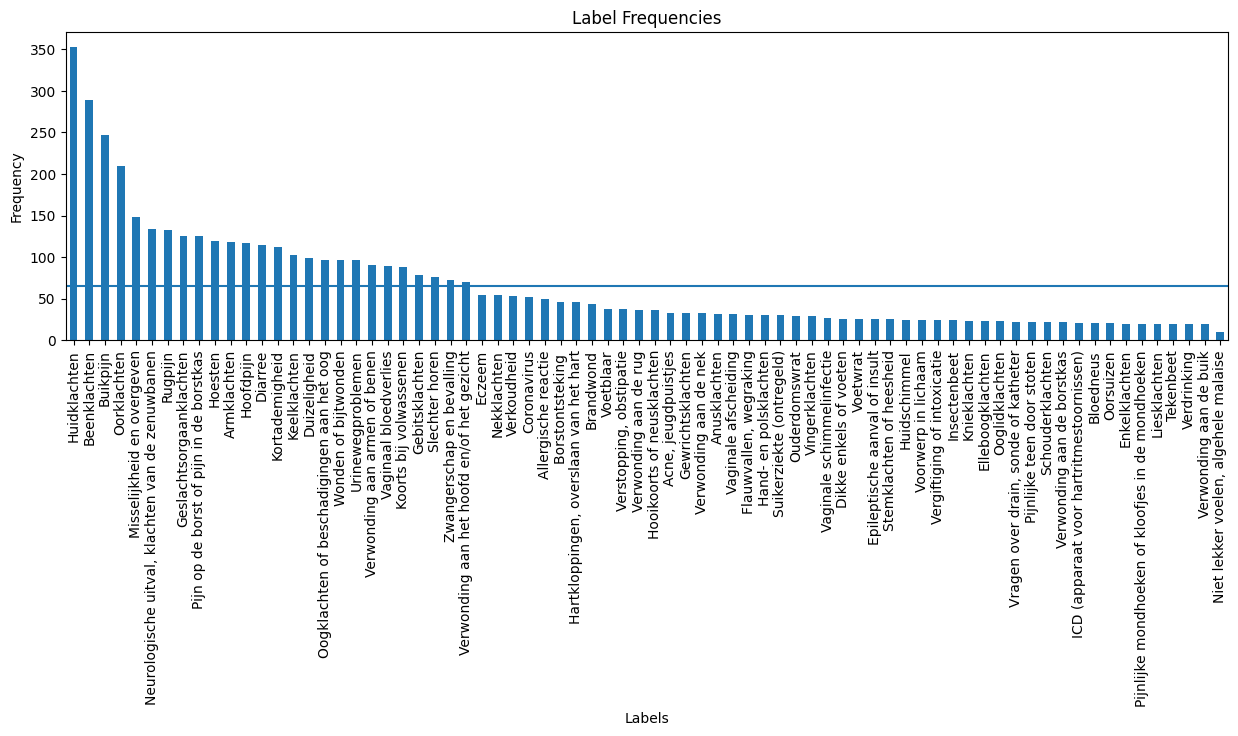

In [7]:
# Plot frequencies of each label to show class imbalances
label_frequencies = df_labels.sum().sort_values(ascending=False)

plt.figure(figsize=(15, 4))
label_frequencies.plot(kind='bar')
plt.title('Label Frequencies')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.axhline(y=label_frequencies.mean())
plt.show()

**Observation:** Seems like there is pretty significant class imbalance. We set a threshold at frequency = 65, which is the mean and also the point where there seems to be a drop-off, so any labels below that we consider a minority class

**Implications for next steps**
- Oversampling rare classes (from frequency < 65) or using class weights in the model
- Choosing evaluation metrics that are less sensitive to class imbalance. E.g. F1 or AUC-ROC, rather than accuracy which can be misleading in imbalanced datasets

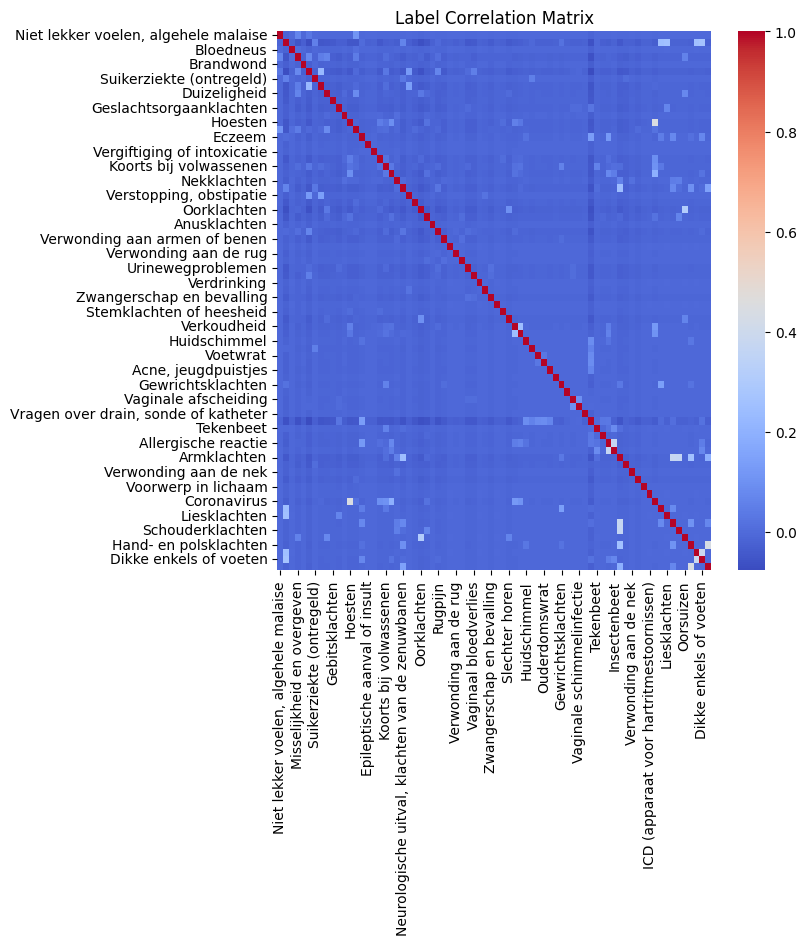

In [8]:
# Calculate correlation between different labels
label_correlation = df_labels.corr()

# Plot the correlation matrix
plt.figure(figsize=(7, 7))
sns.heatmap(label_correlation, annot=False, cmap='coolwarm')
plt.title('Label Correlation Matrix')
plt.show()

**Observation**: Seems like most labels have low correlations with each other, and only a few labels showing moderate correlations.

**Implication for next steps**: No need for special / complex feature engineering or data preprocessing. Priority should then be addressing class imbalance and multi-class/-label

#**2. Model Building**

##**2.1. ML Algorithms (Baseline)**

### **2.1.1. Data Preparation**

Due to the nature of multi-label classification, here we prioritize stratified sampling to maintain a representative distribution of all label combinations in both training and test sets. The tradeoff is then we have to opt to vectorize the entire dataset first and then use `iterative_train_test_split`. Test data should remain unseen during training process, so ideally vectorization should happen after split, but this doesn't work with `iterative_train_test_split`. So we prioritize label distribution at the cost of some potential information leakage.

In the future, with more time, I would write a custom stratified split function where I could stratify based on labels and then vectorize after. This would combine the advantages of both stratification and preventing data leakage.

In [9]:
# Vectorize text data and convert labels to a dense array format
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df_user_inputs['text'])
X = X.toarray()
y = df_labels.values

# Split the data into training and test sets (using sklearn for multi-label classification)
# Stratification is included (albeit bit different for multi-label)
X_train, y_train, X_test, y_test = iterative_train_test_split(X, y, test_size = 0.2)

# Sanity checks to confirm the shapes of the datasets
assert X_train.shape[0] == y_train.shape[0], "Mismatch in train data and labels"
assert X_test.shape[0] == y_test.shape[0], "Mismatch in test data and labels"

X_train.shape, y_train.shape

((3175, 5000), (3175, 74))

In [10]:
## Handle class imbalance
# Custom oversample minority classes in a multi-label setting
def custom_oversample(X, y, threshold=65):
    """
    Perform custom oversampling on the minority classes in the dataset.

    Args:
        X (numpy.ndarray): Feature data.
        y (numpy.ndarray): Label data.
        threshold (int): The threshold below which a class is considered a minority class.

    Returns:
        numpy.ndarray: The oversampled feature data.
        numpy.ndarray: The oversampled label data.
    """

    # Identify minority classes
    minority_labels = (y.sum(axis=0) < threshold)
    # Identify instances with minority class labels
    minority_instances = y[:, minority_labels].sum(axis=1) > 0
    # Oversample these instances
    X_oversampled = np.vstack([X[minority_instances]] * 3)
    y_oversampled = np.vstack([y[minority_instances]] * 3)
    # Combine with original data
    X_combined = np.vstack([X, X_oversampled])
    y_combined = np.vstack([y, y_oversampled])

    return X_combined, y_combined

# Apply the oversampling function to training data
X_train, y_train = custom_oversample(X_train, y_train)

# Sanity check
assert X_train.shape[0] == y_train.shape[0], "Mismatch in oversampled train data and labels"
X_train.shape, y_train.shape

((7063, 5000), (7063, 74))

### **2.1.2. Model Development and Experimentation**

For simplicity, we train and evaluate base classifiers with OneVsRestClassifier. We select classifiers that are known to work well with multi-class text classification, such as Naive Bayes, SVM, and Logistic Regression.

To handle class imbalance, we consider the following:
- Class weights
- Report F1 score (micro) for individual labels and Hamming loss for overall metrics

We identify the best-performing classifier based on the F1 score and Hamming Loss. Then we proceed to test this classifer with more advanced techniques that consider label correlations.

To select these advanced techniques, we consider:
- We have 3974 rows which is a moderate size
- Our feature space is relatively large with 5184 features after vectorization
- We have 74 different labels, which is a substantial number. This can increase the complexity of the classification task, especially for methods that consider all possible label combinations.

Given this information, we select Classifier Chains (CC) and Random k-Labelsets (RAkEL).

In [ ]:
def clf_multilabel(clf_ml_name, clf_base, X_train, y_train, X_test, y_test):
    """
    Evaluate a base classifier with different multi-label classification strategies.

    Args:
        clf_ml_name (str): Name of the multi-label classification strategy to use.
        clf_base (BaseEstimator): The base classifier to be used in the multi-label strategy.
        X_train (numpy.ndarray): Training feature data.
        y_train (numpy.ndarray): Training label data.
        X_test (numpy.ndarray): Test feature data.
        y_test (numpy.ndarray): Test label data.

    Returns:
        dict: A dictionary containing the method, classifier name, F1 Score (Micro), and Hamming Loss.
    """

    if clf_ml_name == "OneVsRestClassifier":
        clf = OneVsRestClassifier(clf_base)
    elif clf_ml_name == "ClassifierChain":
        clf = ClassifierChain(clf_base)
    elif clf_ml_name == "Rakel":
        k = int(0.1 * y_train.shape[1])  # 10% of the total number of labels
        clf = RakelD(base_classifier=clf_base, labelset_size=k)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='micro')
    hamming = hamming_loss(y_test, y_pred)

    return {
        'Method': clf_ml_name,
        'Classifier Name': type(clf_base).__name__,
        'F1 Score (Micro)': f1,
        'Hamming Loss': hamming
    }

In [ ]:
# Evaluate base classifiers with OneVsRestClassifier
base_classifiers = {
    'GaussianNB': GaussianNB(),
    'LinearSVC': LinearSVC(class_weight='balanced'),
    'LogisticRegression': LogisticRegression(solver='liblinear', class_weight='balanced'),
    #'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced')
}

# Collect all performance metrics
all_performance_metrics = []

for name, clf in base_classifiers.items():
    performance_metrics = clf_multilabel("OneVsRestClassifier", clf, X_train, y_train, X_test, y_test)
    all_performance_metrics.append(performance_metrics)

# Identify the best classifier based on F1 Score
best_classifier_name = max(all_performance_metrics, key=lambda x: x['F1 Score (Micro)'])['Classifier']
best_classifier = base_classifiers[best_classifier_name]

# Use the best classifier with Classifier Chains and Random k-Labelsets
all_performance_metrics.append(clf_multilabel("ClassifierChain", best_classifier, X_train, y_train, X_test, y_test))
all_performance_metrics.append(clf_multilabel("Rakel", best_classifier, X_train, y_train, X_test, y_test))

# Convert to DataFrame for easier analysis
df_performance = pd.DataFrame(all_performance_metrics)
df_performance

,Method,Classifier,F1 Score (Micro),Hamming Loss
0,OneVsRestClassifier,GaussianNB,0.276390,0.024000
1,OneVsRestClassifier,LinearSVC,0.585113,0.012160
2,OneVsRestClassifier,LogisticRegression,0.594595,0.013953
3,ClassifierChain,LogisticRegression,0.553708,0.016795
4,Rakel,LogisticRegression,0.522918,0.012499


Best performing classifier is LogisticRegression with OneVsRestClassifier with 0.59 F1 Score, so we use this as our baseline model. A simple OneVsRestClassifier working makes sense, since from our EDA, we see most user inputs (84%) are only associated with 1 label.

In [ ]:
# Get the best classifier to serialize later
best_clf = best_classifier
best_clf = OneVsRestClassifier(best_clf)
best_clf.fit(X_train, y_train)

y_pred = best_clf.predict(X_test)
f1 = f1_score(y_test, y_pred, average='micro')
hamming = hamming_loss(y_test, y_pred)

f1, hamming

(0.5945945945945945, 0.013953252376281162)

### **2.1.3. Serial Best ML Model**

In [ ]:
dump(best_clf, '/content/drive/MyDrive/complaint_prediction_sklearn.joblib')

['/content/drive/MyDrive/complaint_prediction_sklearn.joblib']

## **2.2. SpaCy NL**

### **2.2.1. Data & Model Preparation**

Unfortunately iterative_train_test_split doesn't work straightforward with spacy, because spacy wants input to be text and not vectorized (which is the input required for iterative_train_test_split)

In [11]:
# Split data to train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(df_user_inputs["text"], df_labels, test_size = 0.2, random_state=42)

In [12]:
def initialize_spacy_model(model_size="sm"):
  """
  Initialize and return a spaCy model with a text classification component.
  Args:
      model_size (str): Size of the spaCy Dutch language model.
  Returns:
      spacy.Language: An initialized spaCy model.
  """
  nlp = spacy.load(f'nl_core_news_{model_size}')

  """
  # If we have more time, we could add in transformer which could boost performance
  # Configure the transformer
  transformer_config = {
      "model": {
          "@architectures": "spacy-transformers.TransformerModel.v1",
          "name": "wietsedv/bert-base-dutch-cased",
          "tokenizer_config": {"use_fast": True},
          "get_spans": {"@span_getters": "spacy-transformers.strided_spans.v1", "window": 128, "stride": 96}
      }
  }

  # Add transformer to the pipeline
  #transformer = nlp.add_pipe("transformer", config=transformer_config)
  """

  # Add text classification component
  textcat = nlp.add_pipe("textcat_multilabel", last=True)

  # Add labels to text classifier
  for label in df_labels.columns:
      textcat.add_label(label)

  nlp.initialize()

  return nlp

In [39]:
def prepare_spacy_training_data(model_size="sm"):
  """
  Prepares the training data in the format required by spaCy for model training.

  Args:
      model_size (str): The size of the pre-trained spaCy Dutch language model to use.

  Returns:
      list: A list of spaCy Example objects representing the training data.
  """

  nlp = initialize_spacy_model(model_size) # just for spacy data preparation

  train_data = []
  for text, labels in zip(train_texts, train_labels.values):
      doc = nlp.make_doc(text)
      example = Example.from_dict(doc, {"cats": {label: labels[idx] for idx, label in enumerate(df_labels.columns)}})
      train_data.append(example)

  return train_data

train_data = prepare_spacy_training_data()
print(f"# training examples: {len(train_data)}")

# training examples: 3179


In [29]:
def custom_oversample_spacy(train_data, df_labels, threshold=65):
    """
    Applies custom oversampling to the minority classes in the training data to address class imbalance.

    Args:
        train_data (list): The list of training data examples (spaCy Example objects).
        df_labels (pd.DataFrame): The DataFrame containing the labels for each training example.
        threshold (int): The threshold for identifying minority classes to be oversampled.

    Returns:
        list: The modified training data after applying oversampling.
    """

    # Convert labels to a numpy array for processing
    labels = np.array([list(example.y.cats.values()) for example in train_data])
    # Identify minority classes
    minority_labels = (labels.sum(axis=0) < threshold)
    # Identify instances with minority class labels
    minority_instances = labels[:, minority_labels].sum(axis=1) > 0
    # Oversample these instances
    oversampled_data = [train_data[i] for i, is_minority in enumerate(minority_instances) if is_minority]
    # Combine with original data
    combined_data = train_data + oversampled_data * 3

    return combined_data

train_data_oversampled = custom_oversample_spacy(train_data, df_labels)
print(f"# training examples after oversampling: {len(train_data_oversampled)}")

# training examples after oversampling: 7097


In [34]:
# Prepare test data
def prepare_spacy_test_data(model_size="sm"):
  """
  Prepares the test data in the format required by spaCy for model evaluation.

  Args:
      model_size (str): The size of the pre-trained spaCy Dutch language model to use.

  Returns:
      list: A list of spaCy Example objects representing the test data.
  """
  nlp = initialize_spacy_model(model_size) # just for spacy data preparation

  test_data = []
  for text, labels in zip(test_texts, test_labels.values):
      doc = nlp.make_doc(text)
      example = Example.from_dict(doc, {"cats": {label: labels[idx] for idx, label in enumerate(df_labels.columns)}})
      test_data.append(example)

  return test_data

test_data = prepare_spacy_test_data()
print(f"# test examples: {len(test_data)}")

# test examples: 795


### **2.2.2. Model Development and Experimentation**

In [30]:
def train_spacy_model(model_size="sm"):
  """
  Train a spaCy model using k-fold cross-validation and return the trained model.
  Args:
      model_size (str): Size of the spaCy Dutch language model.
  Returns:
      spacy.Language: A trained spaCy model.
  """
  N_EPOCHS = 15
  BATCH_SIZE = 128
  DROPOUT = 0.2

  train_data = prepare_spacy_training_data(model_size)

  kf = KFold(n_splits=5, shuffle=True, random_state=42)
  f1_scores = []
  hamming_losses = []

  # Cross-validation
  for fold, (train_indices, val_indices) in enumerate(kf.split(train_data)):
      print(f"Fold {fold + 1}")

      nlp = initialize_spacy_model(model_size)  # Initialize a new model for each fold

      train_fold = [train_data[i] for i in train_indices]
      val_fold = [train_data[i] for i in val_indices]

      for epoch in range(N_EPOCHS):
          losses = {}
          random.shuffle(train_fold)
          for batch in minibatch(train_fold, size=BATCH_SIZE):
              nlp.update(batch, drop=DROPOUT, losses=losses)
          print(f"Losses at epoch {epoch}: {losses['textcat_multilabel']}")

      # Evaluate on validation fold
      y_true = np.array([list(example.y.cats.values()) for example in val_fold])
      y_pred = np.array([list(nlp(example.x.text).cats.values()) for example in val_fold])
      y_pred_binary = (y_pred >= 0.5).astype(int)
      f1 = f1_score(y_true, y_pred_binary, average='micro')
      hamming = hamming_loss(y_true, y_pred_binary)

      f1_scores.append(f1)
      hamming_losses.append(hamming)

  return nlp, f1_scores, hamming_losses

In [31]:
## Evaluate spacy model on validation data from training averaged across k-folds
def evaluate_spacy_validation(f1_scores, hamming_losses):
  """
  Evaluates and prints the average F1 score and Hamming loss across validation folds.

  Args:
      f1_scores (list): List of F1 scores from each validation fold.
      hamming_losses (list): List of Hamming loss values from each validation fold.
  """

  # Calculate and print average metrics
  average_f1 = np.mean(f1_scores)
  average_hamming = np.mean(hamming_losses)
  print(f"Average Validation F1 Score: {average_f1}")
  print(f"Average Validation Hamming Loss: {average_hamming}")

In [32]:
## Evaluate spacy model on test data
def evaluate_spacy_test(nlp, test_data):
  """
  Evaluates the spaCy model on the test data and prints the F1 score and Hamming loss.

  Args:
      nlp (spacy.Language): The trained spaCy model.
      test_data (list): A list of spaCy Example objects representing the test data.
  """

  # Predict and evaluate
  y_true_test = np.array([list(example.y.cats.values()) for example in test_data])
  y_pred_test = np.array([list(nlp(example.x.text).cats.values()) for example in test_data])

  # Binarize y_pred_test
  y_pred_test_binary = (y_pred_test >= 0.5).astype(int)

  # Calculate F1 score and Hamming loss for the test set
  f1_test = f1_score(y_true_test, y_pred_test_binary, average='micro')
  hamming_test = hamming_loss(y_true_test, y_pred_test_binary)

  print(f"Test F1 Score: {f1_test}")
  print(f"Test Hamming Loss: {hamming_test}")

#### **2.2.2.1. Spacy NL Small**

In [16]:
nlp_sm, f1_scores, hamming_losses = train_spacy_model(model_size="sm")

Fold 1
Losses at epoch 0: 2.3713773172348738
Losses at epoch 1: 0.3371081752702594
Losses at epoch 2: 0.3195428280159831
Losses at epoch 3: 0.30825861636549234
Losses at epoch 4: 0.2913232780992985
Losses at epoch 5: 0.27482920326292515
Losses at epoch 6: 0.2616780176758766
Losses at epoch 7: 0.24933787155896425
Losses at epoch 8: 0.2335812421515584
Losses at epoch 9: 0.22307888604700565
Losses at epoch 10: 0.2114835400134325
Losses at epoch 11: 0.20139740966260433
Losses at epoch 12: 0.1946813464164734
Losses at epoch 13: 0.18789712898433208
Losses at epoch 14: 0.17888623382896185


/usr/local/lib/python3.10/dist-packages/spacy/pipeline/attributeruler.py:149: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  matches = self.matcher(doc, allow_missing=True, as_spans=False)


Fold 2
Losses at epoch 0: 2.15925077162683
Losses at epoch 1: 0.3305518142879009
Losses at epoch 2: 0.3201051168143749
Losses at epoch 3: 0.31178824603557587
Losses at epoch 4: 0.2994179427623749
Losses at epoch 5: 0.28064828366041183
Losses at epoch 6: 0.2609019437804818
Losses at epoch 7: 0.24725488107651472
Losses at epoch 8: 0.23360142577439547
Losses at epoch 9: 0.2214888520538807
Losses at epoch 10: 0.213435934856534
Losses at epoch 11: 0.20194157492369413
Losses at epoch 12: 0.1920324331149459
Losses at epoch 13: 0.18489279318600893
Losses at epoch 14: 0.17633789777755737


/usr/local/lib/python3.10/dist-packages/spacy/pipeline/attributeruler.py:149: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  matches = self.matcher(doc, allow_missing=True, as_spans=False)


Fold 3
Losses at epoch 0: 2.4302603527903557
Losses at epoch 1: 0.3322321679443121
Losses at epoch 2: 0.3190619768574834
Losses at epoch 3: 0.3092637499794364
Losses at epoch 4: 0.29463931173086166
Losses at epoch 5: 0.27806501276791096
Losses at epoch 6: 0.26205767691135406
Losses at epoch 7: 0.24753129575401545
Losses at epoch 8: 0.23410549946129322
Losses at epoch 9: 0.22075641807168722
Losses at epoch 10: 0.20859447866678238
Losses at epoch 11: 0.1999088805168867
Losses at epoch 12: 0.19269984494894743
Losses at epoch 13: 0.18463663384318352
Losses at epoch 14: 0.17805146891623735


/usr/local/lib/python3.10/dist-packages/spacy/pipeline/attributeruler.py:149: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  matches = self.matcher(doc, allow_missing=True, as_spans=False)


Fold 4
Losses at epoch 0: 2.3289095908403397
Losses at epoch 1: 0.33008349034935236
Losses at epoch 2: 0.3183416295796633
Losses at epoch 3: 0.30863639898598194
Losses at epoch 4: 0.2935025002807379
Losses at epoch 5: 0.2760517690330744
Losses at epoch 6: 0.2607171982526779
Losses at epoch 7: 0.24710964411497116
Losses at epoch 8: 0.23520002141594887
Losses at epoch 9: 0.22255911491811275
Losses at epoch 10: 0.2105021346360445
Losses at epoch 11: 0.2005546186119318
Losses at epoch 12: 0.1930488431826234
Losses at epoch 13: 0.1819045040756464
Losses at epoch 14: 0.1755641344934702


/usr/local/lib/python3.10/dist-packages/spacy/pipeline/attributeruler.py:149: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  matches = self.matcher(doc, allow_missing=True, as_spans=False)


Fold 5
Losses at epoch 0: 2.1719068363308907
Losses at epoch 1: 0.32760853692889214
Losses at epoch 2: 0.3183219116181135
Losses at epoch 3: 0.3078358108177781
Losses at epoch 4: 0.2914196327328682
Losses at epoch 5: 0.2735640136525035
Losses at epoch 6: 0.25644111540168524
Losses at epoch 7: 0.23965657129883766
Losses at epoch 8: 0.22840147092938423
Losses at epoch 9: 0.21882448624819517
Losses at epoch 10: 0.20859433617442846
Losses at epoch 11: 0.20063278917223215
Losses at epoch 12: 0.19227569364011288
Losses at epoch 13: 0.18522613681852818
Losses at epoch 14: 0.17919932212680578


/usr/local/lib/python3.10/dist-packages/spacy/pipeline/attributeruler.py:149: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  matches = self.matcher(doc, allow_missing=True, as_spans=False)


In [ ]:
evaluate_spacy_validation(f1_scores, hamming_losses)

Average Validation F1 Score: 0.3679382981483884
Average Validation Hamming Loss: 0.014121375849411756


In [ ]:
evaluate_spacy_test(nlp_sm, test_data)

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/attributeruler.py:149: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  matches = self.matcher(doc, allow_missing=True, as_spans=False)


Test F1 Score: 0.3633516053249804
Test Hamming Loss: 0.013819479857215706


#### **2.2.2.2. Spacy NL Medium**

In [33]:
nlp_md, f1_scores_md, hamming_losses_md = train_spacy_model(model_size="md")

Fold 1
Losses at epoch 0: 2.2346785236150026
Losses at epoch 1: 0.3314242595806718
Losses at epoch 2: 0.3195321736857295
Losses at epoch 3: 0.3110061101615429
Losses at epoch 4: 0.29914180003106594
Losses at epoch 5: 0.2836329946294427
Losses at epoch 6: 0.2676255004480481
Losses at epoch 7: 0.2516925195232034
Losses at epoch 8: 0.2382935807108879
Losses at epoch 9: 0.22589232493191957
Losses at epoch 10: 0.21489117480814457
Losses at epoch 11: 0.20461596827954054
Losses at epoch 12: 0.1956656537950039
Losses at epoch 13: 0.18645709287375212
Losses at epoch 14: 0.17835506424307823


/usr/local/lib/python3.10/dist-packages/spacy/pipeline/attributeruler.py:149: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  matches = self.matcher(doc, allow_missing=True, as_spans=False)


Fold 2
Losses at epoch 0: 2.3024875074625015
Losses at epoch 1: 0.33048758562654257
Losses at epoch 2: 0.3188609965145588
Losses at epoch 3: 0.3065740531310439
Losses at epoch 4: 0.2915424695238471
Losses at epoch 5: 0.2737392270937562
Losses at epoch 6: 0.25922076869755983
Losses at epoch 7: 0.245085627771914
Losses at epoch 8: 0.2306494051590562
Losses at epoch 9: 0.2203311324119568
Losses at epoch 10: 0.20766449719667435
Losses at epoch 11: 0.1997357252985239
Losses at epoch 12: 0.19182480918243527
Losses at epoch 13: 0.18233257438987494
Losses at epoch 14: 0.17949594790115952


/usr/local/lib/python3.10/dist-packages/spacy/pipeline/attributeruler.py:149: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  matches = self.matcher(doc, allow_missing=True, as_spans=False)


Fold 3
Losses at epoch 0: 2.12049706839025
Losses at epoch 1: 0.33340889029204845
Losses at epoch 2: 0.31894345581531525
Losses at epoch 3: 0.3087325170636177
Losses at epoch 4: 0.2928024996072054
Losses at epoch 5: 0.27564600110054016
Losses at epoch 6: 0.25921313650906086
Losses at epoch 7: 0.24359350558370352
Losses at epoch 8: 0.22956690844148397
Losses at epoch 9: 0.21650173794478178
Losses at epoch 10: 0.20812199730426073
Losses at epoch 11: 0.19809570908546448
Losses at epoch 12: 0.1887404965236783
Losses at epoch 13: 0.17925970070064068
Losses at epoch 14: 0.173675081692636


/usr/local/lib/python3.10/dist-packages/spacy/pipeline/attributeruler.py:149: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  matches = self.matcher(doc, allow_missing=True, as_spans=False)


Fold 4
Losses at epoch 0: 2.6897518541663885
Losses at epoch 1: 0.34319604374468327
Losses at epoch 2: 0.31880916748195887
Losses at epoch 3: 0.31004223227500916
Losses at epoch 4: 0.2972081871703267
Losses at epoch 5: 0.28174345288425684
Losses at epoch 6: 0.2650144761428237
Losses at epoch 7: 0.24856797978281975
Losses at epoch 8: 0.23368092998862267
Losses at epoch 9: 0.22013232484459877
Losses at epoch 10: 0.21059628389775753
Losses at epoch 11: 0.19915291760116816
Losses at epoch 12: 0.1902588438242674
Losses at epoch 13: 0.18197464477270842
Losses at epoch 14: 0.17395608080551028


/usr/local/lib/python3.10/dist-packages/spacy/pipeline/attributeruler.py:149: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  matches = self.matcher(doc, allow_missing=True, as_spans=False)


Fold 5
Losses at epoch 0: 2.111675437539816
Losses at epoch 1: 0.3275410560891032
Losses at epoch 2: 0.31857931707054377
Losses at epoch 3: 0.30906617268919945
Losses at epoch 4: 0.29440081771463156
Losses at epoch 5: 0.2794097336009145
Losses at epoch 6: 0.26447016652673483
Losses at epoch 7: 0.2504755035042763
Losses at epoch 8: 0.23645516857504845
Losses at epoch 9: 0.22287457063794136
Losses at epoch 10: 0.21229274198412895
Losses at epoch 11: 0.20052696019411087
Losses at epoch 12: 0.19344874192029238
Losses at epoch 13: 0.18404603842645884
Losses at epoch 14: 0.17682382930070162


/usr/local/lib/python3.10/dist-packages/spacy/pipeline/attributeruler.py:149: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  matches = self.matcher(doc, allow_missing=True, as_spans=False)


In [35]:
evaluate_spacy_validation(f1_scores_md, hamming_losses_md)

Average Validation F1 Score: 0.4558874185648234
Average Validation Hamming Loss: 0.013126665515612179


In [36]:
evaluate_spacy_test(nlp_md, test_data)

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/attributeruler.py:149: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  matches = self.matcher(doc, allow_missing=True, as_spans=False)


Test F1 Score: 0.47829181494661926
Test Hamming Loss: 0.012459629440761516


#### **2.2.2.3. Spacy NL Large**

In [44]:
nlp_lg, f1_scores_lg, hamming_losses_lg = train_spacy_model(model_size="lg")

Fold 1
Losses at epoch 0: 2.279127709567547
Losses at epoch 1: 0.32655603159219027
Losses at epoch 2: 0.3184195328503847
Losses at epoch 3: 0.3084828210994601
Losses at epoch 4: 0.2924613179638982
Losses at epoch 5: 0.2764954213052988
Losses at epoch 6: 0.26189754996448755
Losses at epoch 7: 0.24844418466091156
Losses at epoch 8: 0.23408174328505993
Losses at epoch 9: 0.21837980952113867
Losses at epoch 10: 0.20637365989387035
Losses at epoch 11: 0.19807590078562498
Losses at epoch 12: 0.19120612181723118
Losses at epoch 13: 0.18371477164328098
Losses at epoch 14: 0.17522133374586701


/usr/local/lib/python3.10/dist-packages/spacy/pipeline/attributeruler.py:149: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  matches = self.matcher(doc, allow_missing=True, as_spans=False)


Fold 2
Losses at epoch 0: 2.125525312498212
Losses at epoch 1: 0.3282166514545679
Losses at epoch 2: 0.3191717155277729
Losses at epoch 3: 0.3101095147430897
Losses at epoch 4: 0.2972076078876853
Losses at epoch 5: 0.28228361066430807
Losses at epoch 6: 0.2676993701606989
Losses at epoch 7: 0.25351100601255894
Losses at epoch 8: 0.2384600192308426
Losses at epoch 9: 0.22572973277419806
Losses at epoch 10: 0.21323804091662169
Losses at epoch 11: 0.20205053500831127
Losses at epoch 12: 0.1927648577839136
Losses at epoch 13: 0.18437131540849805
Losses at epoch 14: 0.17493134643882513


/usr/local/lib/python3.10/dist-packages/spacy/pipeline/attributeruler.py:149: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  matches = self.matcher(doc, allow_missing=True, as_spans=False)


Fold 3
Losses at epoch 0: 2.113502649590373
Losses at epoch 1: 0.3279837528243661
Losses at epoch 2: 0.31735110003501177
Losses at epoch 3: 0.30903551913797855
Losses at epoch 4: 0.29506316129118204
Losses at epoch 5: 0.27786017023026943
Losses at epoch 6: 0.26030897069722414
Losses at epoch 7: 0.24359755590558052
Losses at epoch 8: 0.23062879033386707
Losses at epoch 9: 0.2183362916111946
Losses at epoch 10: 0.20500178541988134
Losses at epoch 11: 0.1976371333003044
Losses at epoch 12: 0.18896380346268415
Losses at epoch 13: 0.18135351408272982
Losses at epoch 14: 0.1752243465743959


/usr/local/lib/python3.10/dist-packages/spacy/pipeline/attributeruler.py:149: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  matches = self.matcher(doc, allow_missing=True, as_spans=False)


Fold 4
Losses at epoch 0: 2.39257306791842
Losses at epoch 1: 0.3307462763041258
Losses at epoch 2: 0.3189757103100419
Losses at epoch 3: 0.3109194254502654
Losses at epoch 4: 0.29753627721220255
Losses at epoch 5: 0.281950231641531
Losses at epoch 6: 0.26424622628837824
Losses at epoch 7: 0.24935086071491241
Losses at epoch 8: 0.23320561740547419
Losses at epoch 9: 0.2193621564656496
Losses at epoch 10: 0.2079819291830063
Losses at epoch 11: 0.19923757296055555
Losses at epoch 12: 0.1904961485415697
Losses at epoch 13: 0.18400853220373392
Losses at epoch 14: 0.17797634983435273


/usr/local/lib/python3.10/dist-packages/spacy/pipeline/attributeruler.py:149: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  matches = self.matcher(doc, allow_missing=True, as_spans=False)


Fold 5
Losses at epoch 0: 2.4857021160423756
Losses at epoch 1: 0.34029112942516804
Losses at epoch 2: 0.3199877766892314
Losses at epoch 3: 0.3115523010492325
Losses at epoch 4: 0.29738102946430445
Losses at epoch 5: 0.278805460780859
Losses at epoch 6: 0.2633902756497264
Losses at epoch 7: 0.24854944925755262
Losses at epoch 8: 0.23223583307117224
Losses at epoch 9: 0.21986745949834585
Losses at epoch 10: 0.2109966054558754
Losses at epoch 11: 0.20087575539946556
Losses at epoch 12: 0.19336291262879968
Losses at epoch 13: 0.1860638721846044
Losses at epoch 14: 0.17861309740692377


/usr/local/lib/python3.10/dist-packages/spacy/pipeline/attributeruler.py:149: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  matches = self.matcher(doc, allow_missing=True, as_spans=False)


In [45]:
print(f1_scores_lg)
print(hamming_losses_lg)
evaluate_spacy_validation(f1_scores_lg, hamming_losses_lg)

[0.4601924759405075, 0.45844269466316706, 0.4600694444444445, 0.46099290780141844, 0.4873362445414847]
[0.013109807921128676, 0.01315230324664287, 0.01321604623491416, 0.012918578956314805, 0.012492019578633752]
Average Validation F1 Score: 0.4654067534782045
Average Validation Hamming Loss: 0.012977751187526854


In [46]:
evaluate_spacy_test(nlp_lg, test_data)

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/attributeruler.py:149: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  matches = self.matcher(doc, allow_missing=True, as_spans=False)


Test F1 Score: 0.44476744186046513
Test Hamming Loss: 0.012986571477137514


The low validation and test F1 scores suggest that the model's performance in classifying the multi-label data is not that great. The fact that both validation and test scores are similar indicates that the model is not overfitting. However, the low F1 scores could point to underfitting or a model that struggles to capture the complexities of the data.

The Hamming loss being around 0.014 for both validation and test suggests a low rate of incorrect label assignments, which is good, but the F1 score implies there's room for improvement in the model's precision and recall balance.

Suggested next steps for future:
1. Implement Transformer-based Models: Try models like BERT or LLM (e.g. GPT, Llama2, Bloom, Mistral, etc) for better contextual understanding.
2. Hyperparameter Tuning: Adjust learning rates, epochs, and batch sizes to optimize performance.
3. Data Augmentation: Enhance the dataset, focusing on minority classes to address imbalance.
4. Advanced Preprocessing: Refine text preprocessing to improve feature extraction.
5. Error Analysis: Identify specific weaknesses of the model and target improvements accordingly.



### **2.2.3. Serial Best SpaCy NL Model (Medium)**

In [41]:
# Save the trained model to a local directory in Google Colab
output_directory = '/content/drive/MyDrive/complaint_prediction_spacy'  # Replace with your desired output directory

# Create the output directory if it doesn't exist
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Save the trained model to the output directory
nlp_md.to_disk(output_directory)

# Verify that the model has been saved
print(f"Model saved to {output_directory}")

Model saved to /content/drive/MyDrive/complaint_prediction_spacy
